In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

In [2]:
SEED_NUMBER = 212
random.seed(SEED_NUMBER)
np.random.seed(SEED_NUMBER)

# ------------------------------
# 1. GridWorld environment
# ------------------------------

In [3]:
class GridWorld:
    def __init__(self, rows=2, cols=3):
        self.rows = rows
        self.cols = cols
        self.grid = np.zeros((rows, cols))  # 0 = normal cell (reward 0)
        self._build_world()
        self.state = self.start_state

    def _build_world(self):
        """Create a fixed goal and obstacle on a 2x3 grid by default."""
        self.start_state = (self.rows - 1, 0)

        # Fixed goal and obstacle locations
        self.goal_state = (0, self.cols - 1)
        self.obstacle_state = (self.rows - 1, self.cols - 1)

        # Fill grid with rewards
        self.grid.fill(0.0)
        self.grid[self.goal_state] = 1.0  # reward for goal
        self.grid[self.obstacle_state] = -1.0  # penalty for obstacle

    def reset(self):
        """Start a new episode from the start state."""
        self.state = self.start_state
        return self.state

    def is_terminal(self, state):
        """Episode ends when we hit the goal or the obstacle."""
        return self.grid[state] == 1 or self.grid[state] == -1

    def get_next_state(self, state, action):
        """Actions: 0 = up, 1 = right, 2 = down, 3 = left."""
        i, j = state
        if action == 0:  # up
            i = max(0, i - 1)
        elif action == 1:  # right
            j = min(self.cols - 1, j + 1)
        elif action == 2:  # down
            i = min(self.rows - 1, i + 1)
        elif action == 3:  # left
            j = max(0, j - 1)
        return (i, j)

    def step(self, action):
        """Take one step in the environment."""
        next_state = self.get_next_state(self.state, action)
        reward = self.grid[next_state]
        self.state = next_state
        done = self.is_terminal(next_state)
        return next_state, reward, done

# ------------------------------
# 2. Q-learning agent
# ------------------------------

In [4]:
class QLearningAgent:
    def __init__(
        self,
        state_shape,
        learning_rate=0.1,
        discount_factor_gamma=0.9,
        exploration_rate_epsilon=0.1,
    ):
        # Q[row, col, action] = value of taking that action in that state
        self.q_table = np.zeros(state_shape + (4,))  # 4 actions
        self.learning_rate = learning_rate  # α
        self.discount_factor_gamma = discount_factor_gamma  # γ
        self.exploration_rate_epsilon = exploration_rate_epsilon  # ε

    def choose_action(self, state):
        """ε-greedy: sometimes explore, otherwise exploit."""
        if random.uniform(0, 1) < self.exploration_rate_epsilon:
            return random.randint(0, 3)  # Explore (random action)
        return int(np.argmax(self.q_table[state]))  # Exploit (best known action)

    def update_q_value(self, state, action, reward, next_state, done):
        """
        Tabular Q-learning update:
        Q(s,a) ← Q(s,a) + α [ r + γ max_a' Q(s',a') - Q(s,a) ]
        If next_state is terminal, we use just r as the target.
        """
        current_q = self.q_table[state][action]

        if done:
            target = reward
        else:
            max_future_q = np.max(self.q_table[next_state])
            target = reward + self.discount_factor_gamma * max_future_q

        self.q_table[state][action] = current_q + self.learning_rate * (
            target - current_q
        )

# ------------------------------
# 3. Visualization helpers
# ------------------------------

In [5]:
def format_state_for_display(state):
    """
    Convert internal (row, col) to display (x, y) with (0,0) at top-left:
    x = col (horizontal), y = row (vertical).
    """
    i, j = state
    return f"({j},{i})"


def plot_gridworld(env):
    """
    Show the grid with:
      - light blue = normal state
      - red = obstacle (X)
      - green = goal (G)
      - coordinates (x, y) inside each cell, with (0,0) at top-left
    Use this at the *start* to explain the state space.
    """
    cmap = ListedColormap(["lightblue", "red", "green"])

    viz_grid = np.zeros_like(env.grid)
    viz_grid[env.grid == -1] = 1  # obstacle
    viz_grid[env.grid == 1] = 2  # goal

    plt.figure(figsize=(6, 4))
    plt.imshow(viz_grid, cmap=cmap)

    # Coordinate labels inside each cell
    # x = column (j), y = row (i), (0,0) is top-left
    for i in range(env.rows):
        for j in range(env.cols):
            plt.text(j, i, f"({j},{i})", ha="center", va="center")

    # Mark special cells (S, G, X) - positions unchanged, just markers
    si, sj = env.start_state
    plt.text(sj, si, "S", ha="center", va="bottom", fontweight="bold")
    gi, gj = env.goal_state
    plt.text(gj, gi, "G", ha="center", va="bottom", fontweight="bold")
    oi, oj = env.obstacle_state
    plt.text(oj, oi, "X", ha="center", va="bottom", fontweight="bold")

    plt.xticks(range(env.cols))
    plt.yticks(range(env.rows))
    plt.title("GridWorld (with coordinates)")
    plt.grid(False)
    plt.show()


def print_q_table(agent, env):
    """
    Very explicit, block-by-block Q-table print.
    Each block is one state; each line is one action.
    Coordinates are shown as (x, y) with (0,0) at top-left:
    x = col, y = row.
    """
    action_names = ["UP", "RIGHT", "DOWN", "LEFT"]

    print("Q-table (one block per state):")
    print("For each state (x, y), we show the value of each possible action.")
    print("Higher numbers = better actions for that state (according to the agent).")

    for i in range(env.rows):  # row (y)
        for j in range(env.cols):  # col (x)
            print(f"State (x={j}, y={i})")
            for a_index, a_name in enumerate(action_names):
                value = agent.q_table[i, j, a_index]
                print(f"  {a_name:>5}: {value:6.2f}")
            print()  # blank line between states
    print()


def plot_policy_on_grid(env, agent):
    """
    Plot the learned policy on the grid itself.

    - red   = obstacle (X)
    - green = goal (G)
    - light blue = other cells
    - in each non-terminal cell we draw an arrow for the best action
    - NO coordinates inside boxes here (kept clean for the policy view)
    """
    cmap = ListedColormap(["lightblue", "red", "green"])

    viz_grid = np.zeros_like(env.grid)
    viz_grid[env.grid == -1] = 1  # obstacle
    viz_grid[env.grid == 1] = 2  # goal

    plt.figure(figsize=(6, 4))
    plt.imshow(viz_grid, cmap=cmap)

    arrow_symbols = ["↑", "→", "↓", "←"]

    for i in range(env.rows):
        for j in range(env.cols):
            cell_reward = env.grid[i, j]
            if cell_reward == 1:
                # Goal
                plt.text(j, i, "G", ha="center", va="center", fontweight="bold")
            elif cell_reward == -1:
                # Obstacle
                plt.text(j, i, "X", ha="center", va="center", fontweight="bold")
            else:
                # Non-terminal: draw arrow for best action
                best_action = int(np.argmax(agent.q_table[i, j]))
                arrow = arrow_symbols[best_action]
                plt.text(j, i, arrow, ha="center", va="center", fontsize=14)

    # Mark the start state with a small 'S' near the top of its cell
    si, sj = env.start_state
    plt.text(sj, si, "S", ha="center", va="bottom", fontweight="bold")

    plt.xticks(range(env.cols))
    plt.yticks(range(env.rows))
    plt.title("Learned policy on the grid (arrows = best action)")
    plt.grid(False)
    plt.show()


def run_greedy_episode(env, agent, max_steps=20):
    """
    Run one episode using the learned greedy policy (no exploration)
    and print the sequence of states.
    States are printed as (x, y) with (0,0) at top-left.
    """
    state = env.reset()
    done = False
    path = [state]
    steps = 0
    reward = 0.0

    while not done and steps < max_steps:
        action = int(np.argmax(agent.q_table[state]))
        next_state, reward, done = env.step(action)
        path.append(next_state)
        state = next_state
        steps += 1

    print("One greedy episode after training:")
    print(" -> ".join(format_state_for_display(s) for s in path))
    if done:
        print("Episode finished with reward:", reward)
    else:
        print("Did not reach terminal state within max steps. Last reward:", reward)

# ------------------------------
# 4. Training loop
# ------------------------------

Grid rewards (1 = goal, -1 = obstacle, 0 = other):
[[ 0.  0.  1.]
 [ 0.  0. -1.]]


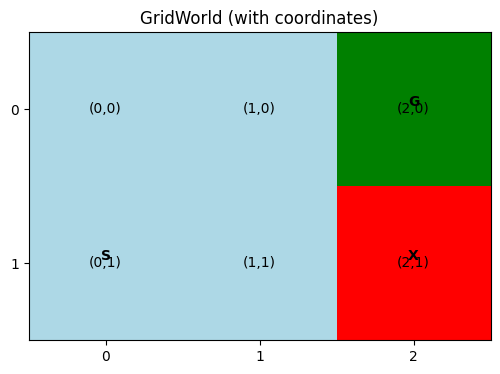

In [6]:
env = GridWorld()

print("Grid rewards (1 = goal, -1 = obstacle, 0 = other):")
print(env.grid)
plot_gridworld(env)  # Visualize the world at the start

In [7]:
agent = QLearningAgent(
    state_shape=env.grid.shape,
    learning_rate=0.1,  # α
    discount_factor_gamma=0.99,  # γ
    exploration_rate_epsilon=0.5,  # ε
)

In [8]:
episodes = 150000  # Number of training episodes

for episode in range(episodes):
    state = env.reset()
    done = False

    while not done:
        action = agent.choose_action(state)  # choose action a
        next_state, reward, done = env.step(action)  # take action, get r, s'
        agent.update_q_value(state, action, reward, next_state, done)  # update Q(s,a)
        state = next_state

# ------------------------------
# 5. What did the agent learn?
# ------------------------------

Q-table (one block per state):
For each state (x, y), we show the value of each possible action.
Higher numbers = better actions for that state (according to the agent).
State (x=0, y=0)
     UP:   0.98
  RIGHT:   0.99
   DOWN:   0.97
   LEFT:   0.98

State (x=1, y=0)
     UP:   0.99
  RIGHT:   1.00
   DOWN:   0.98
   LEFT:   0.98

State (x=2, y=0)
     UP:   0.00
  RIGHT:   0.00
   DOWN:   0.00
   LEFT:   0.00

State (x=0, y=1)
     UP:   0.98
  RIGHT:   0.98
   DOWN:   0.97
   LEFT:   0.97

State (x=1, y=1)
     UP:   0.99
  RIGHT:  -1.00
   DOWN:   0.98
   LEFT:   0.97

State (x=2, y=1)
     UP:   0.00
  RIGHT:   0.00
   DOWN:   0.00
   LEFT:   0.00




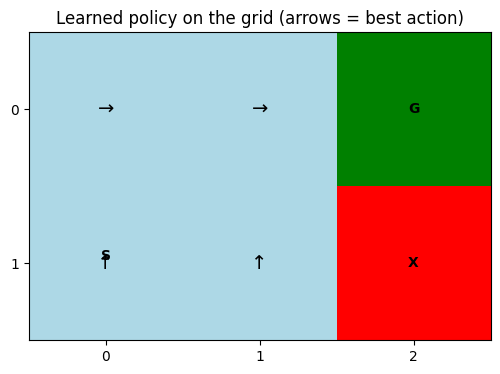

One greedy episode after training:
(0,1) -> (0,0) -> (1,0) -> (2,0)
Episode finished with reward: 1.0


In [9]:
print_q_table(agent, env)  # Text version, very explicit
plot_policy_on_grid(env, agent)  # Visual policy on the grid
run_greedy_episode(env, agent)  # Show one greedy path